# The downstream tracking study based on sklearn framework.
## Study of the T-seed selection using BDT classifier

This script contains all of my study based on **XGBoost**.

## Study roadmap 
--------------
1. Train  the first version of xgboost with default parameters and without any features engeenering. Just to know baseline score. 
2. Add basic features transforamtion eg. pseudorapidity and abs. 
3. Tune hiperparameters using GridSearchCV
4. Try RandomizedSearchCV
5. Compare following result with Bayesian Optimization


Features descriptions
=================
As mentioned in the [problem description](http://localhost:7000/notebooks/SeedClasifier/Baseline.ipynb#Problem-description) paragraph the Seed classifier take into account only T-Seeds parameters. 
The input T-seeds are stored as a [Event/Track.h](https://lhcb-release-area.web.cern.ch/LHCb-release-area/DOC/rec/latest_doxygen/df/dfc/_track_8h_source.html) data structure. 

T-Seed tagging
-----------
To mark T-Seed as a good track it need to fulfil following criteria: 
1. Has associated MC (Monte Carlo) particle
2. Reconstructable as a downstream track but not as a long track 
    2.1 Has clusters only in the TT and T station
    2.2 No hits in Velo
3. The MC particle is not an electron

See [implementation](https://github.com/adendek/DownstreamTracking/blob/master/BrunelCode/Tr/PatDebugTTTruthTool.cpp#L220). 

Meaning of each T-Seed parameters
---------------

1. seed_chi2PerDof - track's chi^2 per degree of freedom of the track,  
2. seed_p, seed_pt - momentum and transverse momentum of this track,
3. seed_nLHCbIDs - number of hits associated to the T-Seed,
4. seed_niIT -  number of IT hits associated to the T-Seed,
5. seed - number of used T station layers,
6. seed_x, seed_y - x and y coordinate T-Seed projection onto first plate of T-Station
7. seed_tx, seed_ty - x and y coordinate of the T-Seed slope

See [implementation](https://github.com/adendek/DownstreamTracking/blob/master/BrunelCode/Tr/PatDebugTTTruthTool.cpp#L282) of the code responsive for creation of the training NTuple. 


In [1]:
print ("kernel is alive!")

kernel is alive!


In [48]:
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# xgboost 
import xgboost as xgb
from xgboost import plot_importance

# bayesian optimization
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours


### As a very first step I need to grab training data form the NTpule. 
To obtain this goal I will use **root_numpy**, that allows me to convert root NTuple to pandas.Dataframe

In [3]:
train_data_file = "Brunel_BdJPsiKs_MagU_30k.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value"] , axis=1).astype(np.float64)

target = data.is_downstream_reconstructible
features = features.drop(features.columns[0], axis=1)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.447929,1849.101146,1083.522737,27.0,0.0,12.0,-1418.736880,-143.095899,-0.722093,-0.038671
1,0.354945,10085.622823,1345.148537,24.0,0.0,12.0,-393.699553,-284.193871,-0.129122,-0.037920
2,2.906524,2441.534682,1013.888408,24.0,0.0,12.0,-834.004914,-270.235334,-0.456235,-0.015198
3,3.234916,2604.073941,904.097232,24.0,0.0,12.0,-475.119652,-230.380918,-0.369728,-0.018967
4,0.842265,2644.554049,1068.602364,23.0,0.0,12.0,-899.187260,-101.826800,-0.440227,-0.036610


### Print the features distributions

I want to know how doest the features looks like.

In [4]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06
mean,1.871657e+00,2.138872e+04,1.730661e+03,1.792164e+01,2.797962e+00,1.125978e+01,4.302253e-01,-4.526582e+00,-2.401685e-03,-5.792746e-04
std,1.274678e+00,1.528150e+06,6.397556e+04,4.672918e+00,4.762586e+00,1.028624e+00,7.095528e+02,5.222606e+02,3.068898e-01,6.750835e-02
min,1.030490e-03,1.121404e+03,2.736860e+00,8.000000e+00,0.000000e+00,8.000000e+00,-2.536045e+03,-2.368444e+03,-1.303497e+00,-4.931323e-01
25%,9.834252e-01,3.318111e+03,9.752144e+02,1.300000e+01,0.000000e+00,1.100000e+01,-3.969852e+02,-2.058561e+02,-1.735886e-01,-2.951513e-02
50%,1.494130e+00,6.400423e+03,1.153456e+03,1.900000e+01,0.000000e+00,1.200000e+01,9.255241e-01,-3.572218e+00,-3.683508e-03,-2.420115e-04
75%,2.391722e+00,1.445767e+04,1.406610e+03,2.200000e+01,4.000000e+00,1.200000e+01,4.014095e+02,1.991543e+02,1.691624e-01,2.868205e-02
max,8.999642e+00,1.741231e+09,5.879921e+07,3.400000e+01,2.300000e+01,1.200000e+01,2.511015e+03,2.224234e+03,1.307487e+00,4.260690e-01


In [5]:
def print_features_histograms(features, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 2, 2, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = np.percentile(features[feature], [1, 99])
        min_value-=0.1*max_value
        max_value+=0.2*max_value
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(features.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

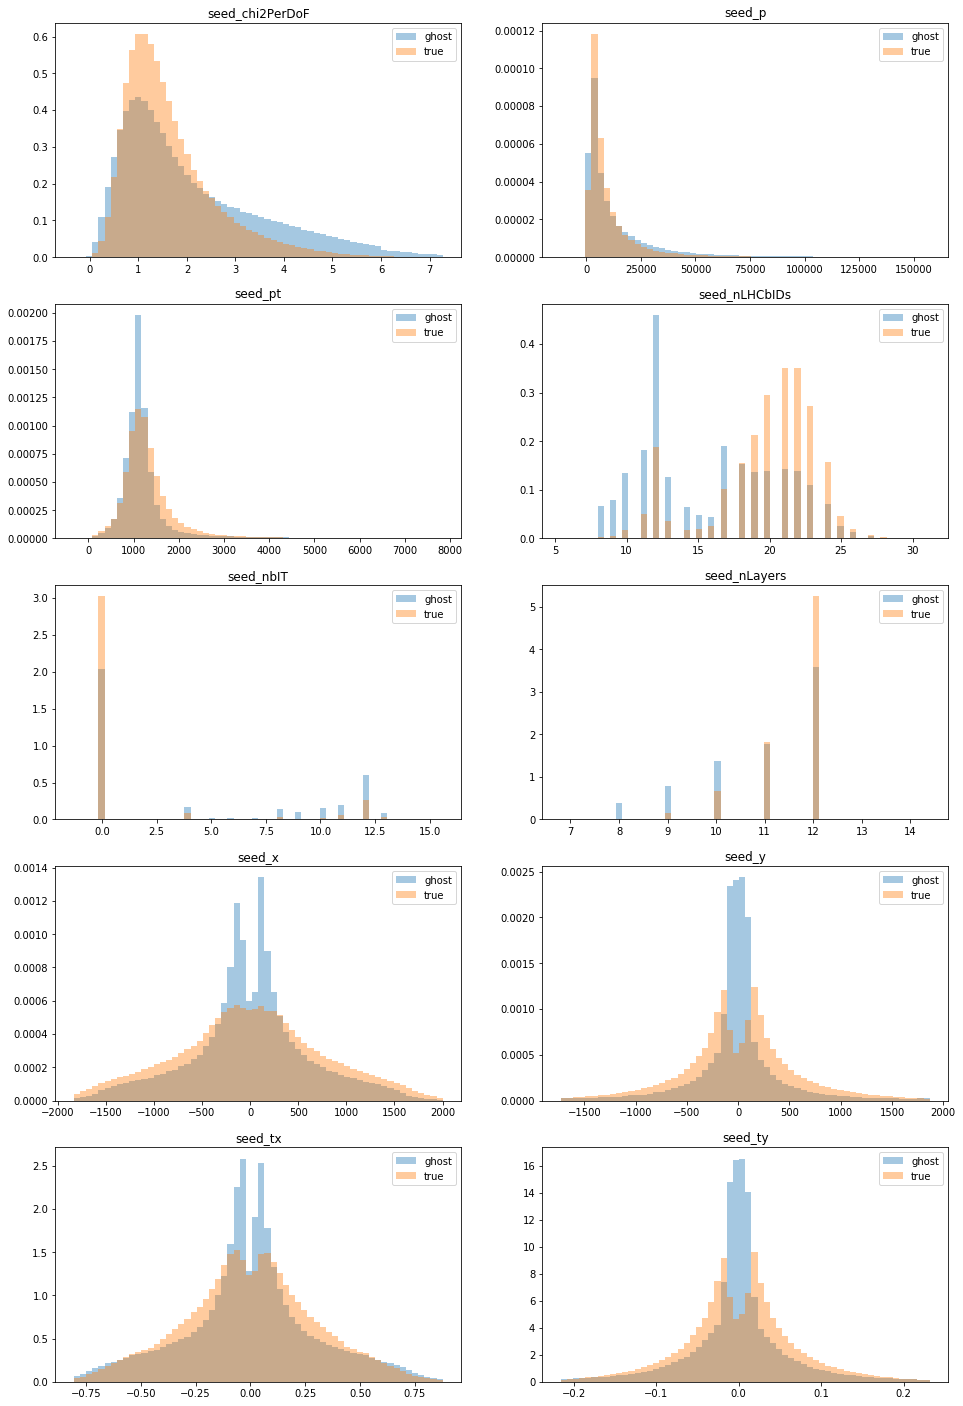

In [6]:
print_features_histograms(features, target)

## Training of the baseline clasifiers
The aim of this step is to find a BDT score without any tuning of the hyperparameters.   
I use sudo-default set of parameters. I also want to build the tools for further usage. 

Split data into train and validation sets
----------------------

In [9]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.9 )

Boosted Decision Tree clasifier
------------------------------
The above plots present's performance of the BDT. It is one of the best classifier, that can be used as a baseline. 

In [23]:
eval_set = [(trainX,trainY), (testX, testY)]
evals_result = {}
eval_metric=["error", "logloss", "auc"]

gb = xgb.XGBClassifier(n_estimators=700, learning_rate=0.07,max_depth=6,
                       objective="gpu:binary:logistic", tree_method="gpu_exact",predictor='gpu_predictor',
                       silent=False, verbose_eval=True, eval_metric=eval_metric, evals_result=evals_result)
gb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric=['error', 'logloss', 'auc'],
       evals_result={}, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=1, nthread=None, objective='gpu:binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1, tree_method='gpu_exact', verbose_eval=True)

In [24]:
%%time
gb.fit(trainX,trainY, eval_set=eval_set)

[0]	validation_0-error:0.212396	validation_0-logloss:0.667415	validation_0-auc:0.83938	validation_1-error:0.213937	validation_1-logloss:0.667547	validation_1-auc:0.837304
[1]	validation_0-error:0.212034	validation_0-logloss:0.645084	validation_0-auc:0.843939	validation_1-error:0.213456	validation_1-logloss:0.645303	validation_1-auc:0.842097
[2]	validation_0-error:0.211624	validation_0-logloss:0.626046	validation_0-auc:0.848866	validation_1-error:0.212993	validation_1-logloss:0.626326	validation_1-auc:0.847262
[3]	validation_0-error:0.20998	validation_0-logloss:0.609109	validation_0-auc:0.853086	validation_1-error:0.21139	validation_1-logloss:0.609452	validation_1-auc:0.851532
[4]	validation_0-error:0.210938	validation_0-logloss:0.594231	validation_0-auc:0.853699	validation_1-error:0.212252	validation_1-logloss:0.594624	validation_1-auc:0.852213
[5]	validation_0-error:0.210085	validation_0-logloss:0.580744	validation_0-auc:0.855168	validation_1-error:0.211357	validation_1-logloss:0.5811

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric=['error', 'logloss', 'auc'],
       evals_result={}, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=1, nthread=None, objective='gpu:binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1, tree_method='gpu_exact', verbose_eval=True)

In [25]:
print("ROC AUC score")
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])

ROC AUC score


0.9377007351326793

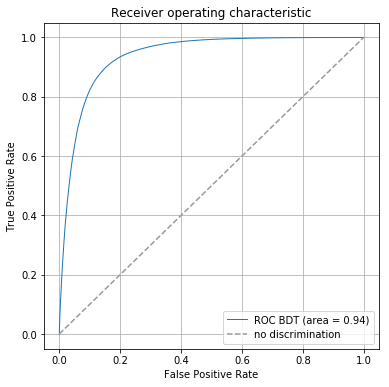

In [26]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Check importance of the features based on the BDT. 

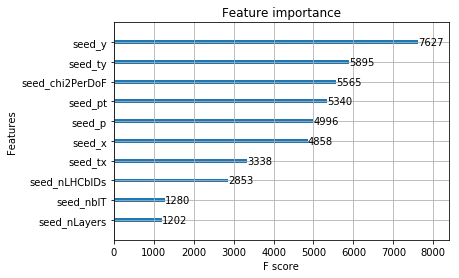

In [27]:
plot_importance(gb);

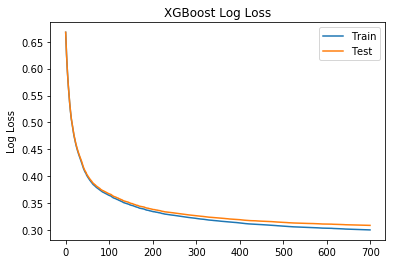

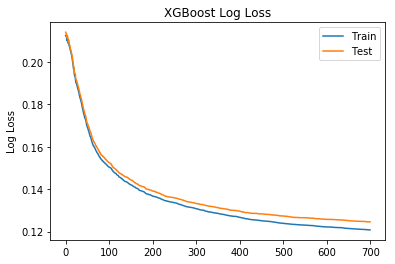

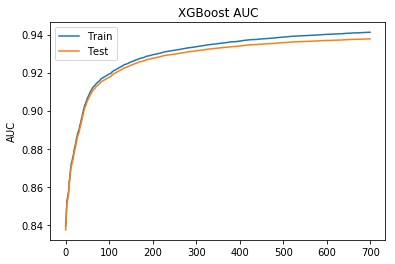

In [31]:
results = gb.evals_result()
epochs = len(results['validation_0']["error"])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["logloss"], label='Train')
ax.plot(x_axis, results['validation_1']["logloss"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["error"], label='Train')
ax.plot(x_axis, results['validation_1']["error"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["auc"], label='Train')
ax.plot(x_axis, results['validation_1']["auc"], label='Test')

ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
import numpy as np
def predict_vs_threshold(probas,threshold):
    predicted = np.where(probas>threshold,1,0)
    return predicted

In [9]:
   
threshold = 0.07

cnf_matrix = confusion_matrix(testY ,predict_vs_threshold(gb.predict_proba(testX),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix')


NameError: name 'testY' is not defined

Normalized confusion matrix
[[0.48224005 0.51775995]
 [0.00570843 0.99429157]]


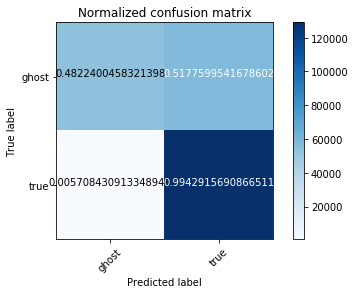

In [35]:
threshold = 0.07

cnf_matrix = confusion_matrix(testY ,predict_vs_threshold(gb.predict_proba(testX),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, normalize=True, classes=target_names,
                      title='Normalized confusion matrix')

# Feature Engenering

## Add transformated features

At the begining let's try some very basic feature transformation. 
I also add pseudorapidity and seed_r

In [5]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=np.abs(data['seed_x'])
    out["abs_seed_y"]=np.abs(data['seed_y'])
    out["abs_seed_tx"]=np.abs(data['seed_tx'])
    out["abs_seed_ty"]=np.abs(data['seed_ty'])
    out['seed_r'] = np.sqrt(np.square(data.seed_x) +np.square(data.seed_y))    
    out['pseudo_rapidity'] = np.arctanh(data.seed_pt/data.seed_p)
    return out

In [6]:
new_data = basic_transforamtion(data)
new_features =  new_data.drop(["is_true_seed","has_MCParticle",
                    "is_downstream_reconstructible",
                    "has_MCParticle_not_electron",
                    "is_downstream_reconstructible_not_electron",
                    "seed_mva_value",
                    "seed_x",
                    "seed_y",
                    "seed_tx",
                    "seed_ty",
                    "Unnamed: 0"          ] , axis=1).astype(np.float64)

new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.447929,1849.101146,1083.522737,27.0,0.0,12.0,1418.736880,143.095899,0.722093,0.038671,1425.935051,0.671511
1,0.354945,10085.622823,1345.148537,24.0,0.0,12.0,393.699553,284.193871,0.129122,0.037920,485.556891,0.134172
2,2.906524,2441.534682,1013.888408,24.0,0.0,12.0,834.004914,270.235334,0.456235,0.015198,876.693408,0.441959
3,3.234916,2604.073941,904.097232,24.0,0.0,12.0,475.119652,230.380918,0.369728,0.018967,528.028457,0.362240
4,0.842265,2644.554049,1068.602364,23.0,0.0,12.0,899.187260,101.826800,0.440227,0.036610,904.934487,0.428511


In [8]:
features_to_print = new_features[["seed_chi2PerDoF","seed_p",
                                "seed_pt",
                                "seed_nLHCbIDs",
                                "abs_seed_x",
                                "abs_seed_y",
                                "abs_seed_tx",
                                "abs_seed_ty",
                                "seed_r",
                                "pseudo_rapidity"]]
print_features_histograms(features_to_print, target)

NameError: name 'print_features_histograms' is not defined

In [ ]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.9 )

In [47]:
eval_set= [(new_trainX,new_trainY), (new_testX, new_testY)]
evals_result = {}
eval_metric=["error", "logloss", "auc"]


gb2 =xgb.XGBClassifier(n_estimators=700, learning_rate=0.07,max_depth=6,
                       objective="gpu:binary:logistic", tree_method="gpu_exact",predictor='gpu_predictor',
                       silent=False, verbose_eval=True, eval_metric=eval_metric, evals_result=evals_result)

In [49]:
%%time
gb2.fit(new_trainX,new_trainY, eval_set=eval_set)

[0]	validation_0-error:0.200158	validation_0-logloss:0.664589	validation_0-auc:0.857597	validation_1-error:0.202012	validation_1-logloss:0.664715	validation_1-auc:0.855913
[1]	validation_0-error:0.198283	validation_0-logloss:0.640396	validation_0-auc:0.863833	validation_1-error:0.199669	validation_1-logloss:0.640598	validation_1-auc:0.862352
[2]	validation_0-error:0.196209	validation_0-logloss:0.618287	validation_0-auc:0.866591	validation_1-error:0.197536	validation_1-logloss:0.618593	validation_1-auc:0.865053
[3]	validation_0-error:0.19558	validation_0-logloss:0.598585	validation_0-auc:0.870762	validation_1-error:0.196804	validation_1-logloss:0.59902	validation_1-auc:0.869146
[4]	validation_0-error:0.192446	validation_0-logloss:0.580515	validation_0-auc:0.875427	validation_1-error:0.193736	validation_1-logloss:0.581024	validation_1-auc:0.873861
[5]	validation_0-error:0.191947	validation_0-logloss:0.564996	validation_0-auc:0.877814	validation_1-error:0.193235	validation_1-logloss:0.565

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric=['error', 'logloss', 'auc'],
       evals_result={}, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=1, nthread=None, objective='gpu:binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1, tree_method='gpu_exact', verbose_eval=True)

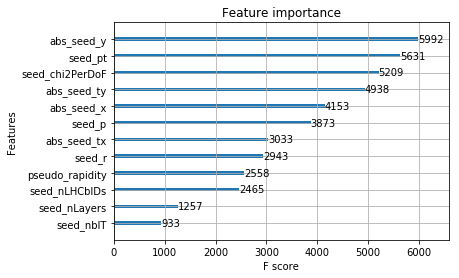

In [53]:
plot_importance(gb);

In [54]:
roc_auc_score(new_testY, gb.predict_proba(new_testX)[:, 1])

0.9415888206282752

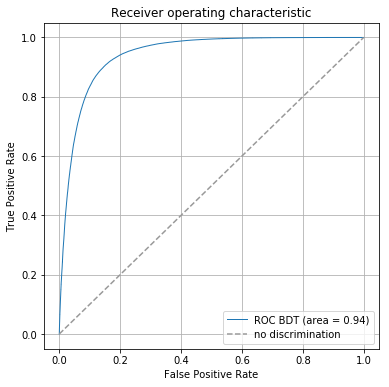

In [55]:
fig = plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()
fig.savefig("ROC_BDT.pdf")

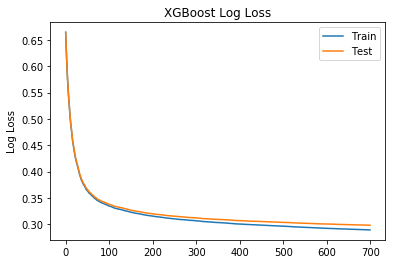

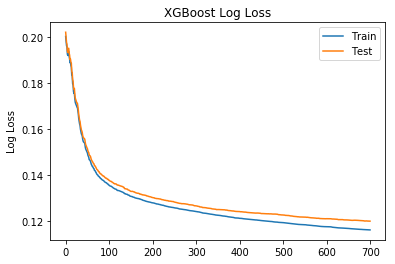

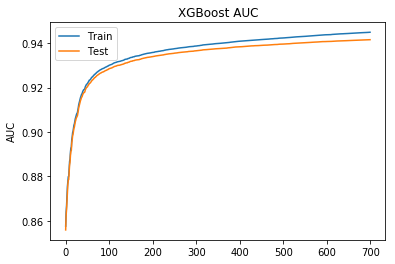

In [57]:
results = gb.evals_result()
epochs = len(results['validation_0']["error"])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["logloss"], label='Train')
ax.plot(x_axis, results['validation_1']["logloss"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["error"], label='Train')
ax.plot(x_axis, results['validation_1']["error"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["auc"], label='Train')
ax.plot(x_axis, results['validation_1']["auc"], label='Test')

ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

Confusion matrix, without normalization
[[ 58785  52927]
 [   849 128959]]


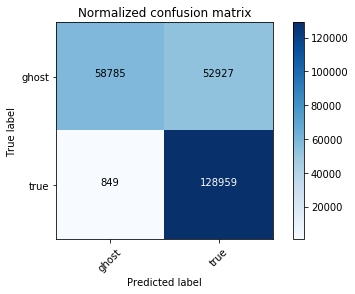

In [61]:
threshold = 0.07

cnf_matrix = confusion_matrix(new_testY ,predict_vs_threshold(gb.predict_proba(new_testX),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix')


Normalized confusion matrix
[[0.63901819 0.36098181]
 [0.0163087  0.9836913 ]]


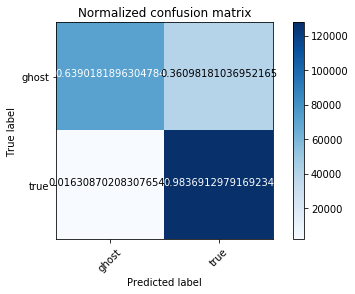

In [65]:
threshold = 0.15

cnf_matrix = confusion_matrix(new_testY ,predict_vs_threshold(gb.predict_proba(new_testX),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, normalize=True,  classes=target_names,
                      title='Normalized confusion matrix')


## Hyperparameters optimalization

I perform following steps to tune the hyperparameters for a gradient boosting model:

1. Choose loss based on your problem at hand (ie. target metric)
2. Pick n_estimators as large as (computationally) possible (e.g. 600).
3. Tune max_depth, learning_rate, min_samples_leaf, and max_features via grid search.
4. Increase n_estimators even more and tune learning_rate again holding the other parameters fixed.
Scikit-learn provides a convenient API for hyperparameter tuning and grid search. 


In [16]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.7 )
gb_grid_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6, 8, 10],
              'min_child_weight':list(range(1,6,2)),
              'max_features': [1.0, 0.8 ,0.5] 
              }
print(gb_grid_params)

gb_gs = xgb.XGBClassifier(n_estimators=300, tree_method='gpu_hist', predictor='gpu_predictor')


tuner = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               refit = True,
                               pre_dispatch=1)
tuner

{'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6, 8, 10], 'min_child_weight': [1, 3, 5], 'max_features': [1.0, 0.8, 0.5]}


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6, 8, 10], 'min_child_weight': [1, 3, 5], 'max_features': [1.0, 0.8, 0.5]},
       pre_dispatch=1, refit=True, scoring='roc_auc', verbose=3)

In [ ]:
tuner.fit(train_gs_X,train_gs_Y )

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=1 
[CV]  learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=1, score=0.929876 -  16.8s
[CV] learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=1, score=0.929869 -  16.5s
[CV] learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=1, score=0.930013 -  16.6s
[CV] learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=3 
[CV]  learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=3, score=0.930052 -  16.7s
[CV] learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=3 
[CV]  learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=3, score=0.930140 -  16.6s
[CV] learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=3 
[CV]  learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=3, score=0.929572 -  16.4s
[CV] learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=5 
[CV]  learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=5, score=0.929799 -  16.8s
[CV] learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=5 
[CV]  learning_rate=0.1, max_depth=4, max_features=1.0, min_child_weight=5, score=0.929732 -  16.6s
[CV] learning_rate=0.1, m

## Train the new model based on GridSearch results
The following set of parameters has been selected: 

* n_estimators=700 (wiil be increased depending on learning curve)
* learning rate=0.1
* max depth = 10 
* max_features=0.5 
* min_child_weight=1

In [13]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.9 )

In [12]:
eval_set= [(new_trainX,new_trainY), (new_testX, new_testY)]
evals_result = {}
eval_metric=["error", "logloss", "auc"]


gb_gs =xgb.XGBClassifier(n_estimators=700, learning_rate=0.1,max_depth=10, max_features=0.5, min_child_weight=1,
                       objective="gpu:binary:logistic", tree_method="gpu_exact",predictor='gpu_predictor',
                       silent=False, verbose_eval=True, eval_metric=eval_metric, evals_result=evals_result)

In [15]:
%%time
gb_gs.fit(new_trainX,new_trainY, eval_set=eval_set)

[0]	validation_0-error:0.155435	validation_0-logloss:0.641931	validation_0-auc:0.904201	validation_1-error:0.158629	validation_1-logloss:0.642383	validation_1-auc:0.901419
[1]	validation_0-error:0.146412	validation_0-logloss:0.600245	validation_0-auc:0.913193	validation_1-error:0.150137	validation_1-logloss:0.601093	validation_1-auc:0.910644
[2]	validation_0-error:0.147211	validation_0-logloss:0.564615	validation_0-auc:0.915718	validation_1-error:0.150795	validation_1-logloss:0.565843	validation_1-auc:0.913049
[3]	validation_0-error:0.14376	validation_0-logloss:0.534996	validation_0-auc:0.917507	validation_1-error:0.147719	validation_1-logloss:0.536598	validation_1-auc:0.91482
[4]	validation_0-error:0.143342	validation_0-logloss:0.509766	validation_0-auc:0.919447	validation_1-error:0.147657	validation_1-logloss:0.511828	validation_1-auc:0.916623
[5]	validation_0-error:0.142157	validation_0-logloss:0.486715	validation_0-auc:0.921999	validation_1-error:0.146402	validation_1-logloss:0.489

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric=['error', 'logloss', 'auc'],
       evals_result={}, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, max_features=0.5, min_child_weight=1, missing=None,
       n_estimators=700, n_jobs=1, nthread=None,
       objective='gpu:binary:logistic', predictor='gpu_predictor',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1, tree_method='gpu_exact',
       verbose_eval=True)

In [17]:
print("ROC AUC score")
roc_auc_score(new_testY, gb_gs.predict_proba(new_testX)[:, 1])

ROC AUC score


0.9475400124189213

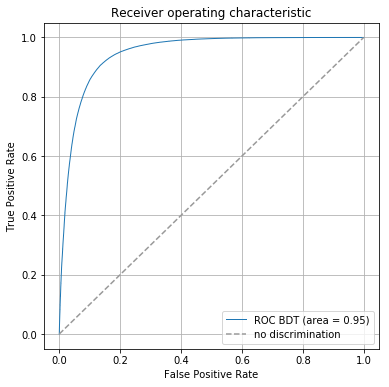

In [18]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb_gs.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

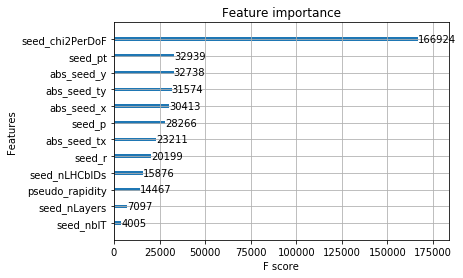

In [20]:
from xgboost import plot_importance
plot_importance(gb_gs);

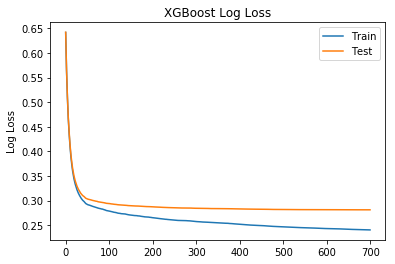

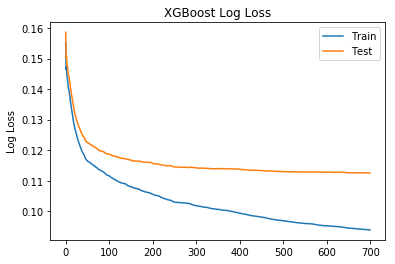

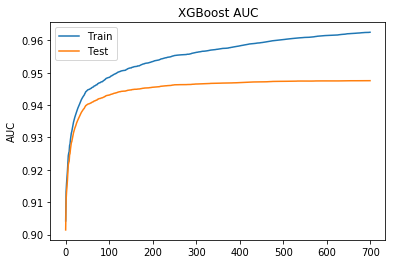

In [22]:
results = gb_gs.evals_result()
epochs = len(results['validation_0']["error"])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["logloss"], label='Train')
ax.plot(x_axis, results['validation_1']["logloss"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["error"], label='Train')
ax.plot(x_axis, results['validation_1']["error"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["auc"], label='Train')
ax.plot(x_axis, results['validation_1']["auc"], label='Test')

ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

Confusion matrix, without normalization
[[ 80229  31483]
 [  3193 126615]]


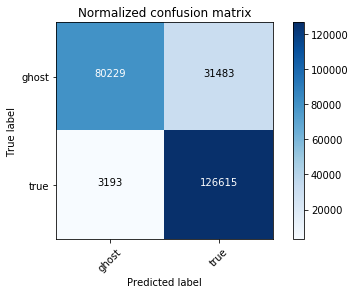

In [36]:
threshold = 0.2


cnf_matrix = confusion_matrix(new_testY ,predict_vs_threshold(gb_gs.predict_proba(new_testX),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix')


Normalized confusion matrix
[[0.7181771  0.2818229 ]
 [0.02459787 0.97540213]]


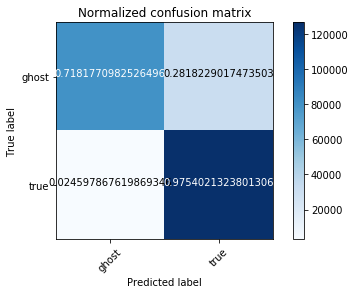

In [35]:
threshold = 0.2

cnf_matrix = confusion_matrix(new_testY ,predict_vs_threshold(gb_gs.predict_proba(new_testX),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, normalize=True,  classes=target_names,
                      title='Normalized confusion matrix')

# Hyperparameter tuning based on RadnomSearch method

This time I will try to find an optimal set of hyperparameters via RadnomSearch method. 

In [23]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.7 )
gb_rs_distributions = {'learning_rate': sp.stats.reciprocal(a=1e-2,b=1.1),
              'max_depth': sp.stats.randint(3,15),
              'min_child_weight':sp.stats.randint(1,6),
              'subsample': sp.stats.uniform(0.25, 0.75),
              'max_features': sp.stats.uniform(0.2,1.0), 
              }

gb_rs = xgb.XGBClassifier(n_estimators=1000, tree_method='gpu_hist', predictor='gpu_predictor', nthread=2,
                          verbose_eval=0,silent=True)


eval_set = [(test_gs_X, test_gs_Y)]

fit_params = {"early_stopping_rounds":20, 
              "eval_metric" : "auc",
              "eval_set": eval_set,
              "verbose":False
             }


random_tuner = RandomizedSearchCV(gb_rs,
                        gb_rs_distributions,
                        cv=3,
                        n_iter=20,
                        scoring='roc_auc',
                        verbose = 3, 
                        refit = True,
                        fit_params  = fit_params,
                        pre_dispatch=1)
random_tuner

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=2, objective='binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist', verbose_eval=0),
          fit_params={'early_stopping_rounds': 20, 'eval_metric': 'auc', 'eval_set': [(         seed_chi2PerDoF         seed_p      seed_pt  seed_nLHCbIDs  \
623302          1.748657   13907.879268  1100.457939           23.0
199913          0.382356    6758.296241   714.254677           15.0
1726917   ...81427     True
Name: is_downstream_reconstructible, Length: 724560, dtype: bool)], 'verbose': False},
          iid=True, n_iter=20, n_jobs=1,
          param_distrib

In [24]:
random_tuner.fit(train_gs_X, train_gs_Y)

/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] learning_rate=0.2105390797835905, max_depth=11, max_features=0.30849057849222733, min_child_weight=1, subsample=0.8612521197045874 
[CV]  learning_rate=0.2105390797835905, max_depth=11, max_features=0.30849057849222733, min_child_weight=1, subsample=0.8612521197045874, score=0.9460457328390195, total=  49.1s
[CV] learning_rate=0.2105390797835905, max_depth=11, max_features=0.30849057849222733, min_child_weight=1, subsample=0.8612521197045874 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.0s remaining:    0.0s


[CV]  learning_rate=0.2105390797835905, max_depth=11, max_features=0.30849057849222733, min_child_weight=1, subsample=0.8612521197045874, score=0.9464526720522033, total=  45.4s
[CV] learning_rate=0.2105390797835905, max_depth=11, max_features=0.30849057849222733, min_child_weight=1, subsample=0.8612521197045874 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV]  learning_rate=0.2105390797835905, max_depth=11, max_features=0.30849057849222733, min_child_weight=1, subsample=0.8612521197045874, score=0.9462306530990754, total=  48.8s
[CV] learning_rate=0.1352639462379595, max_depth=12, max_features=0.7783955658784194, min_child_weight=4, subsample=0.5465791552281335 
[CV]  learning_rate=0.1352639462379595, max_depth=12, max_features=0.7783955658784194, min_child_weight=4, subsample=0.5465791552281335, score=0.9461369025564015, total= 1.1min
[CV] learning_rate=0.1352639462379595, max_depth=12, max_features=0.7783955658784194, min_child_weight=4, subsample=0.5465791552281335 
[CV]  learning_rate=0.1352639462379595, max_depth=12, max_features=0.7783955658784194, min_child_weight=4, subsample=0.5465791552281335, score=0.9466280979596821, total= 1.1min
[CV] learning_rate=0.1352639462379595, max_depth=12, max_features=0.7783955658784194, min_child_weight=4, subsample=0.5465791552281335 
[CV]  learning_rate=0.1352639462379595, max_depth=12, max_fe

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 81.1min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=2, objective='binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist', verbose_eval=0),
          fit_params={'early_stopping_rounds': 20, 'eval_metric': 'auc', 'eval_set': [(         seed_chi2PerDoF         seed_p      seed_pt  seed_nLHCbIDs  \
623302          1.748657   13907.879268  1100.457939           23.0
199913          0.382356    6758.296241   714.254677           15.0
1726917   ...81427     True
Name: is_downstream_reconstructible, Length: 724560, dtype: bool)], 'verbose': False},
          iid=True, n_iter=20, n_jobs=1,
          param_distrib

In [25]:
random_tuner.best_params_

{'learning_rate': 0.049915496699718766,
 'max_depth': 11,
 'max_features': 0.3777993838461427,
 'min_child_weight': 5,
 'subsample': 0.4442307520949027}

In [29]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.9 )
eval_set= [(new_trainX,new_trainY), (new_testX, new_testY)]
evals_result = {}
eval_metric=["error", "logloss", "auc"]


gb_rs =xgb.XGBClassifier(n_estimators=1000, **random_tuner.best_params_, 
                       objective="gpu:binary:logistic", tree_method="gpu_exact",predictor='gpu_predictor',
                       silent=False, verbose_eval=True, eval_metric=eval_metric, evals_result=evals_result)
gb_rs

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric=['error', 'logloss', 'auc'],
       evals_result={}, gamma=0, learning_rate=0.049915496699718766,
       max_delta_step=0, max_depth=11, max_features=0.3777993838461427,
       min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='gpu:binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.4442307520949027, tree_method='gpu_exact',
       verbose_eval=True)

In [30]:
%%time
gb_rs.fit(new_trainX,new_trainY, eval_set=eval_set)

[0]	validation_0-error:0.146004	validation_0-logloss:0.665767	validation_0-auc:0.911521	validation_1-error:0.150807	validation_1-logloss:0.666072	validation_1-auc:0.908163
[1]	validation_0-error:0.139676	validation_0-logloss:0.640887	validation_0-auc:0.920305	validation_1-error:0.1447	validation_1-logloss:0.641483	validation_1-auc:0.917146
[2]	validation_0-error:0.140486	validation_0-logloss:0.61833	validation_0-auc:0.921837	validation_1-error:0.145537	validation_1-logloss:0.619193	validation_1-auc:0.918633
[3]	validation_0-error:0.13757	validation_0-logloss:0.597498	validation_0-auc:0.923754	validation_1-error:0.142584	validation_1-logloss:0.59868	validation_1-auc:0.920278
[4]	validation_0-error:0.137964	validation_0-logloss:0.57845	validation_0-auc:0.924257	validation_1-error:0.142932	validation_1-logloss:0.5799	validation_1-auc:0.920826
[5]	validation_0-error:0.13654	validation_0-logloss:0.560764	validation_0-auc:0.925596	validation_1-error:0.141827	validation_1-logloss:0.562509	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric=['error', 'logloss', 'auc'],
       evals_result={}, gamma=0, learning_rate=0.049915496699718766,
       max_delta_step=0, max_depth=11, max_features=0.3777993838461427,
       min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='gpu:binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.4442307520949027, tree_method='gpu_exact',
       verbose_eval=True)

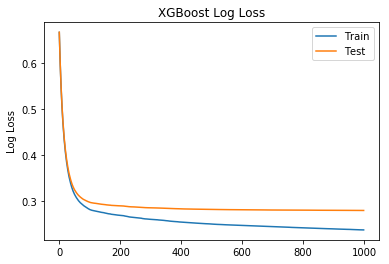

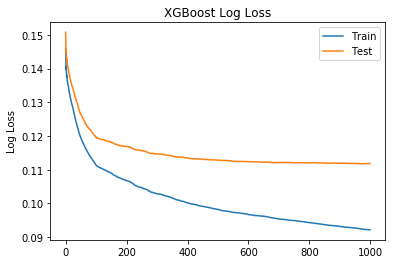

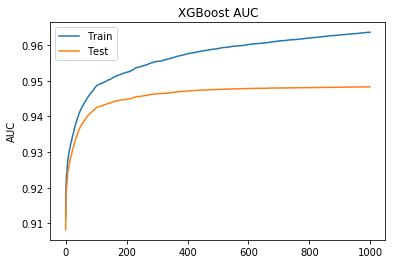

In [31]:
results = gb_rs.evals_result()
epochs = len(results['validation_0']["error"])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["logloss"], label='Train')
ax.plot(x_axis, results['validation_1']["logloss"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["error"], label='Train')
ax.plot(x_axis, results['validation_1']["error"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["auc"], label='Train')
ax.plot(x_axis, results['validation_1']["auc"], label='Test')

ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

In [25]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.9 )
eval_set= [(new_trainX,new_trainY), (new_testX, new_testY)]
evals_result = {}
eval_metric=["error", "logloss", "auc"]


gb_rs_2 =xgb.XGBClassifier(n_estimators=1000, 
                           learning_rate=0.3067462376431885, max_depth=5, max_features=1.161133216098018, min_child_weight=2, subsample=0.9329008023690014,
                        reg_lambda=0.1, reg_alpha=0.001,colsample_bytree=0.5,
                           objective="gpu:binary:logistic", tree_method="gpu_exact",predictor='gpu_predictor',
                           silent=False, verbose_eval=True, eval_metric=eval_metric, evals_result=evals_result)
gb_rs_2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eval_metric=['error', 'logloss', 'auc'],
       evals_result={}, gamma=0, learning_rate=0.3067462376431885,
       max_delta_step=0, max_depth=5, max_features=1.161133216098018,
       min_child_weight=2, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='gpu:binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0.001,
       reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.9329008023690014, tree_method='gpu_exact',
       verbose_eval=True)

In [26]:
%%time
gb_rs_2.fit(new_trainX,new_trainY, eval_set=eval_set)

[0]	validation_0-error:0.216721	validation_0-logloss:0.593049	validation_0-auc:0.83923	validation_1-error:0.216881	validation_1-logloss:0.593348	validation_1-auc:0.838045
[1]	validation_0-error:0.208211	validation_0-logloss:0.537435	validation_0-auc:0.851191	validation_1-error:0.208662	validation_1-logloss:0.538054	validation_1-auc:0.850012
[2]	validation_0-error:0.205553	validation_0-logloss:0.503184	validation_0-auc:0.859232	validation_1-error:0.206525	validation_1-logloss:0.503958	validation_1-auc:0.858217
[3]	validation_0-error:0.196725	validation_0-logloss:0.476986	validation_0-auc:0.872823	validation_1-error:0.197872	validation_1-logloss:0.477828	validation_1-auc:0.871895
[4]	validation_0-error:0.190937	validation_0-logloss:0.457719	validation_0-auc:0.880639	validation_1-error:0.191578	validation_1-logloss:0.458758	validation_1-auc:0.879532
[5]	validation_0-error:0.189332	validation_0-logloss:0.445158	validation_0-auc:0.883072	validation_1-error:0.190034	validation_1-logloss:0.44

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eval_metric=['error', 'logloss', 'auc'],
       evals_result={}, gamma=0, learning_rate=0.3067462376431885,
       max_delta_step=0, max_depth=5, max_features=1.161133216098018,
       min_child_weight=2, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='gpu:binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0.001,
       reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.9329008023690014, tree_method='gpu_exact',
       verbose_eval=True)

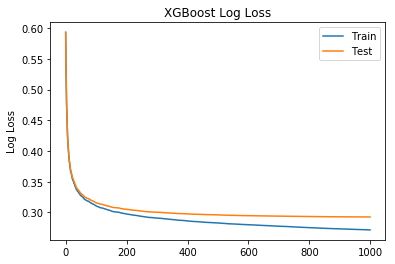

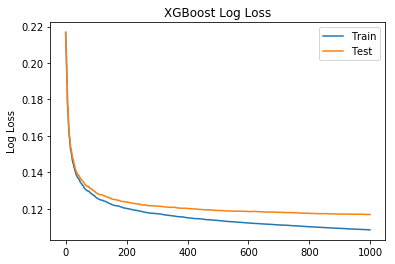

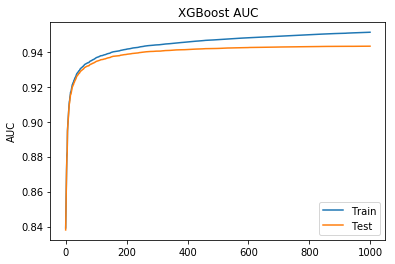

In [27]:
results = gb_rs_2.evals_result()
epochs = len(results['validation_0']["error"])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["logloss"], label='Train')
ax.plot(x_axis, results['validation_1']["logloss"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["error"], label='Train')
ax.plot(x_axis, results['validation_1']["error"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["auc"], label='Train')
ax.plot(x_axis, results['validation_1']["auc"], label='Test')

ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

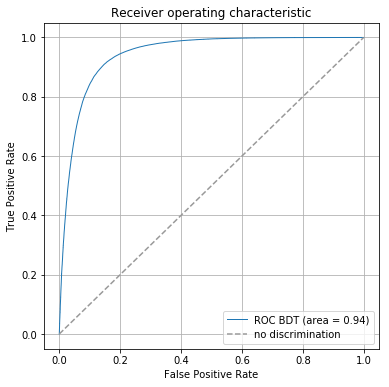

In [28]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb_rs_2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

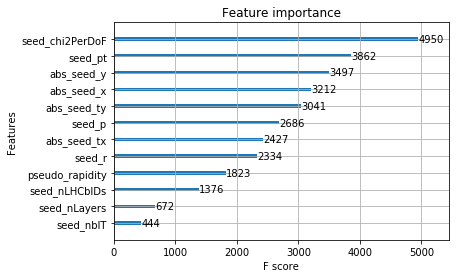

In [51]:
plot_importance(gb_rs_2);

# Bayesian optimization

Now you can go to the next model - BDT base on [XGBoost]( [Logistic Regression](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/BDT-XGBoost.ipynb) or [Logistic Regression](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/LogisticRegression.ipynb)    
=========